# Image Captioning ✨
## Steps: 🚶‍♂️
* Data Collection
* Understanding the data
* Data Cleaning
* Loading the training set
* Data preprocessing - Images & Captions
* Data prepration using generator function
* Word Embeddings
* Model Architecture
* Inference
* Evaluation

In [10]:
## Importing Libraries 
import re
import os
import cv2 
import json
from time import time
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Tensorflow related libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ## Keras libraries
# from keras.preprocessing import sequence, image
# from keras.models import Sequential
# from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
#                          Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
# 
# from keras.optimizers import Adam, RMSprop
# from keras.layers.wrappers import Bidirectional
# from keras.layers.merge import add
# from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.models import Model
# from keras import Input, layers
# from keras import optimizers
# from keras.applications.inception_v3 import preprocess_input
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

C:\Users\YuvrajSK\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\YuvrajSK\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\YuvrajSK\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Data Collection

In [4]:
def readText(path): 
    with open(path) as f: 
        captions = f.read() 
        
    return captions 

captions = readText("data/captions.csv") 
captions = captions.split("\n") 

In [3]:
descriptions = {}

for i in range(1, len(captions)):
    image, *caption = captions[i].split(",")
    image = image.split(".")[0]
    
    if not descriptions.get(image):
        descriptions[image] = []
        
    try:
        descriptions[image].append(caption[0])
    except Exception: 
        pass

In [4]:
descriptions["1007129816_e794419615"]

['A man in an orange hat starring at something .',
 'A man wears an orange hat and glasses .',
 'A man with gauges and glasses is wearing a Blitz hat .',
 'A man with glasses is wearing a beer can crocheted hat .',
 'The man with pierced ears is wearing glasses and an orange hat .']

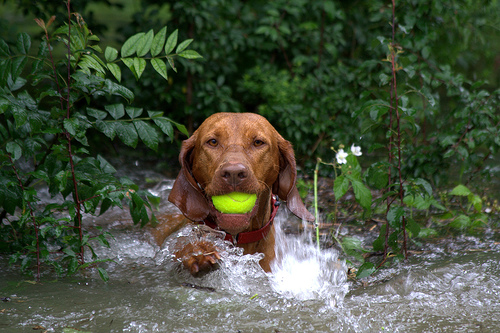

In [6]:
from PIL import Image
from IPython.display import display

img = Image.open("data/Images/"+"1130369873_d80a1aa59c.jpg")
display(img)

In [46]:
import numpy as np
np.array(img)

array([[[31, 30, 28],
        [32, 31, 29],
        [32, 31, 29],
        ...,
        [27, 27, 29],
        [26, 26, 28],
        [26, 26, 28]],

       [[31, 30, 28],
        [32, 31, 29],
        [32, 31, 29],
        ...,
        [26, 26, 28],
        [26, 26, 28],
        [26, 26, 28]],

       [[31, 30, 28],
        [32, 31, 29],
        [32, 31, 29],
        ...,
        [28, 28, 30],
        [27, 27, 29],
        [27, 27, 29]],

       ...,

       [[33, 34, 39],
        [33, 34, 39],
        [33, 34, 39],
        ...,
        [17,  6, 12],
        [18,  7, 13],
        [20,  9, 15]],

       [[32, 33, 38],
        [33, 34, 39],
        [32, 33, 38],
        ...,
        [16,  7, 12],
        [16,  7, 12],
        [18,  9, 14]],

       [[31, 32, 37],
        [33, 34, 39],
        [32, 33, 38],
        ...,
        [ 8,  2,  4],
        [ 7,  2,  6],
        [ 8,  3,  7]]], dtype=uint8)

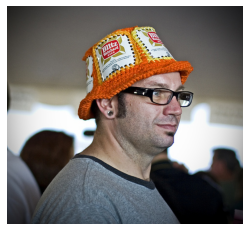

In [62]:
import cv2 
import matplotlib.pyplot as plt


IMG_PATH = "data/Images/"
img = cv2.imread(IMG_PATH + "1007129816_e794419615.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off");

## Data Cleaning

In [3]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)  ## Removing any number and punctuations
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1] ## Only keeping words with length more than one
    sentence = " ".join(sentence)
    return sentence

In [7]:
clean_text("A cat is sitting over the house 35")

'cat is sitting over the house'

In [5]:
# Clean captions
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [9]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [10]:
len(descriptions)

8092

In [64]:
## Saving it to text file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [22]:
## Importing descriptions dictionary
with open("descriptions.txt", "r") as f:
    descriptions = f.read()
    descriptions = json.loads(descriptions.replace("\'", "\""))
    
print(type(descriptions))

<class 'dict'>


## Creating Vocabulary

In [23]:
## Creating unique words list
vocab = set()

for key in descriptions.keys(): 
    for sentence in descriptions[key]: 
        vocab.update(sentence.split()) 

In [10]:
len(vocab)

8257

In [24]:
## Total number of words
total_words = []

for key in descriptions.keys():
    for sentence in descriptions[key]:
        for word in sentence.split():
            total_words.append(word)

In [16]:
len(total_words)

357791

In [25]:
## Creating word counter
counter = Counter(total_words)
freq_count = dict(counter)

## Sorting words according to their count
sorted_freq_count = sorted(freq_count.items(), reverse=True, key= lambda x: x[1])

In [14]:
len(freq_count.keys()), len(vocab), len(sorted_freq_count)

(8257, 8257, 8257)

In [26]:
## Filtering out the words
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1] > threshold]

total_words = [x[0] for x in sorted_freq_count]
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'people',
 'at',
 'water',
 'young',
 'red',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'shirt',
 'while',
 'down',
 'little',
 'standing',
 'ball',
 'grass',
 'person',
 'child',
 'snow',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'small',
 'up',
 'field',
 'holding',
 'large',
 'group',
 'by',
 'green',
 'yellow',
 'children',
 'walking',
 'men',
 'her',
 'into',
 'beach',
 'air',
 'near',
 'jumps',
 'mouth',
 'street',
 'runs',
 'for',
 'another',
 'riding',
 'from',
 'its',
 'as',
 'bike',
 'stands',
 'girls',
 'one',
 'outside',
 'rock',
 'off',
 'player',
 'next',
 'play',
 'out',
 'pink',
 'orange',
 'looking',
 'pool',
 'other',
 'camera',
 'their',
 'boys',
 'jacket',
 'women',
 'hat',
 'around',
 'some',
 'dirt',
 'soccer',
 'sits',
 'behind',
 'toy',
 'dressed',
 'mountain',
 'w

In [16]:
## Total number of possible output words
len(total_words)

1800

### Splitting into train, test and dev datasets

In [33]:
## Dividing images into three parts
imgs = list(descriptions.keys())
train_data = imgs[:6092]
dev_data = imgs[6092:7092]
test_data = imgs[7092:]

In [18]:
len(train_data), len(dev_data), len(test_data)

(6092, 1000, 1000)

In [221]:
## Saving into text files
flickr8k_trainData = ".jpg\n".join(train_data)
flickr8k_testData = ".jpg\n".join(test_data)
flickr8k_devData = ".jpg\n".join(dev_data)

with open("data/Flickr8k.trainImages.txt", "w") as f1:
    f1.write(flickr8k_trainData)
with open("data/Flickr8k.testImages.txt", "w") as f2:
    f2.write(flickr8k_testData)
with open("data/Flickr8k.devImages.txt", "w") as f3:
    f3.write(flickr8k_devData)

In [225]:
train_data

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a',
 '101654506_8eb26cfb60',
 '101669240_b2d3e7f17b',
 '1016887272_03199f49c4',
 '1019077836_6fc9b15408',
 '1019604187_d087bf9a5f',
 '1020651753_06077ec457',
 '1022454332_6af2c1449a',
 '1022454428_b6b660a67b',
 '1022975728_75515238d8',
 '102351840_323e3de834',
 '1024138940_f1fefbdce1',
 '102455176_5f8ead62d5',
 '1026685415_0431cbf574',
 '1028205764_7e8df9a2ea',
 '1030985833_b0902ea560',
 '103106960_e8a41d64f8',
 '103195344_5d2dc613a3',
 '103205630_682ca7285b',
 '1032122270_ea6f0beedb',
 '1032460886_4a598ed535',
 '1034276567_49bb87c51c',
 '104136873_5b5d41be75',
 '1042020065_fb3d3ba5ba',
 '1042590306_95dea0916c',
 '1045521051_108ebc19be',
 '1048710776_bb5b0a5c7c',
 '1052358063_eae6744153',
 '105342180_4d4a40b47f',
 '1053804096_ad278b25

In [34]:
## Creating input descriptions for training with start and end symbols
train_descriptions = {}
 
### Adding start and end token to the traning sentences
for img_id in train_data:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        cap_to_append = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [35]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [13]:
## Creating ResNet50 model
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
model.layers[-2], model.input

(<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D at 0x1edefec70c8>,
 <tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>)

In [14]:
new_model = Model(model.input, model.layers[-2].output)

In [19]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

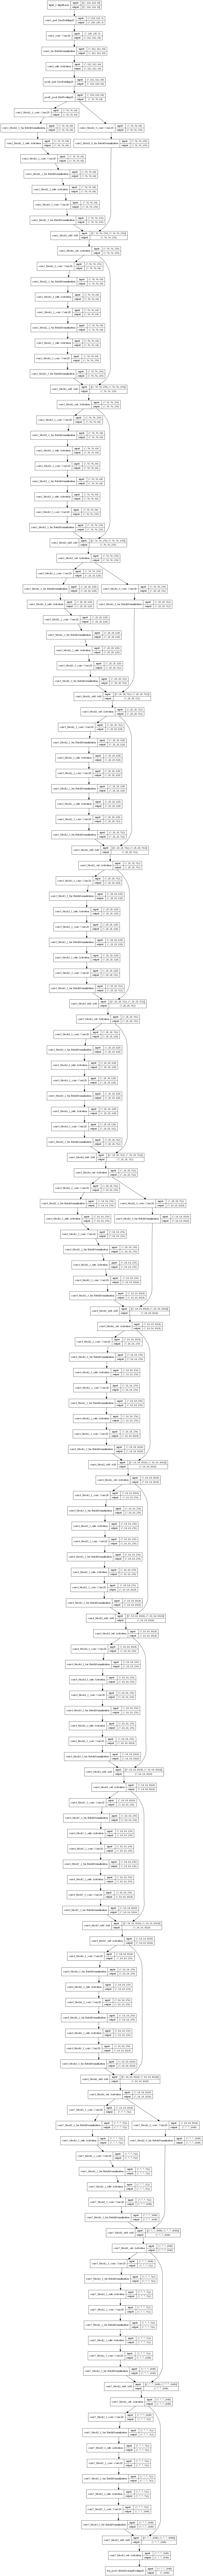

In [27]:
tf.keras.utils.plot_model(new_model, show_shapes=True)

## Image Data Pre-Processing (Image Encoding)

In [11]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224, 3))
    img = image.img_to_array(img)
    
    img = np.expand_dims(img, axis=0) 
    img = preprocess_input(img)
    
    return img

In [27]:
descriptions["1130369873_d80a1aa59c"]

['brown dog is running through neck deep water carrying tennis ball',
 'brown dog splashes in the water while carrying ball in its mouth',
 'brown dog swims through water outdoors with tennis ball in its mouth',
 'red dog',
 'brown dog with tennis ball in mouth']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


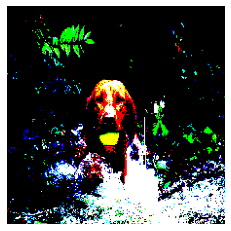

In [31]:
## Testing preprocess image function
test_img = preprocess_image(IMG_PATH + "1130369873_d80a1aa59c.jpg")
plt.imshow(test_img[0][:, :, [2, 1, 0]])
plt.axis("off")
plt.show();

In [38]:
(test_img)

array([[[[ -97.939    ,  -62.779    ,  -93.68     ],
         [ -99.939    ,  -79.779    , -100.68     ],
         [ -97.939    ,  -92.779    , -116.68     ],
         ...,
         [ -67.939    ,  -10.778999 ,  -53.68     ],
         [ -60.939003 ,  -23.779    ,  -64.68     ],
         [ -55.939003 ,  -38.779    ,  -74.68     ]],

        [[ -82.939    ,  -56.779    ,  -84.68     ],
         [ -94.939    ,  -78.779    , -101.68     ],
         [ -85.939    ,  -74.779    , -105.68     ],
         ...,
         [ -55.939003 ,  -10.778999 ,  -52.68     ],
         [ -51.939003 ,  -22.779    ,  -60.68     ],
         [ -51.939003 ,  -36.779    ,  -72.68     ]],

        [[ -77.939    ,  -53.779    ,  -80.68     ],
         [ -89.939    ,  -74.779    , -100.68     ],
         [ -80.939    ,  -65.779    ,  -95.68     ],
         ...,
         [ -51.939003 ,  -10.778999 ,  -54.68     ],
         [ -51.939003 ,  -25.779    ,  -64.68     ],
         [ -48.939003 ,  -33.779    ,  -70.68     ]],

In [28]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [40]:
encode_image(IMG_PATH + "1130369873_d80a1aa59c.jpg")

array([0.27290028, 0.96881884, 0.32253006, ..., 1.5391468 , 1.4217584 ,
       0.38079798], dtype=float32)

## Images to features Transfer Learning

In [41]:
### for training images
encoding_train = {}

def encode_images(data, encoding_dict):
    start = time()

    for ix, img_id in enumerate(data):
        img_path = IMG_PATH + "/" + img_id + ".jpg"
        try:
            encoding_dict[img_id] = encode_image(img_path)
        except Exception:
            pass

        if ix%100 == 0:
            ep_time = time()
            print("[+] Encoding done with %d images...."%ix)
            print("[+] Time taken was %d seconds\n"%(ep_time-start))

    end_t = time()
    print("Total time Taken :", end_t-start)

encode_images(train_data, encoding_train)

[+] Encoding done with 0 images....
[+] Time taken was 1 seconds

[+] Encoding done with 100 images....
[+] Time taken was 22 seconds

[+] Encoding done with 200 images....
[+] Time taken was 42 seconds

[+] Encoding done with 300 images....
[+] Time taken was 63 seconds

[+] Encoding done with 400 images....
[+] Time taken was 83 seconds

[+] Encoding done with 500 images....
[+] Time taken was 104 seconds

[+] Encoding done with 600 images....
[+] Time taken was 138 seconds

[+] Encoding done with 700 images....
[+] Time taken was 158 seconds

[+] Encoding done with 800 images....
[+] Time taken was 181 seconds

[+] Encoding done with 900 images....
[+] Time taken was 204 seconds

[+] Encoding done with 1000 images....
[+] Time taken was 228 seconds

[+] Encoding done with 1100 images....
[+] Time taken was 252 seconds

[+] Encoding done with 1200 images....
[+] Time taken was 276 seconds

[+] Encoding done with 1300 images....
[+] Time taken was 299 seconds

[+] Encoding done with 1

In [47]:
## Saving train features
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [286]:
## For test datasets
encoding_test = {}

encode_images(test_data, encoding_test)

## Saving test dataset
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

[+] Encoding done with 0 images....
[+] Time taken was 0 seconds

[+] Encoding done with 100 images....
[+] Time taken was 21 seconds

[+] Encoding done with 200 images....
[+] Time taken was 42 seconds

[+] Encoding done with 300 images....
[+] Time taken was 64 seconds

[+] Encoding done with 400 images....
[+] Time taken was 85 seconds

[+] Encoding done with 500 images....
[+] Time taken was 108 seconds

[+] Encoding done with 600 images....
[+] Time taken was 133 seconds

[+] Encoding done with 700 images....
[+] Time taken was 157 seconds

[+] Encoding done with 800 images....
[+] Time taken was 181 seconds

[+] Encoding done with 900 images....
[+] Time taken was 207 seconds

Total time Taken : 232.0046272277832


In [288]:
## Encoding & saving dev encoded dataset

encoding_dev = {}

encode_images(dev_data, encoding_dev)

with open("encoded_dev_features.pkl", "wb") as f:
    pickle.dump(encoding_dev, f)

[+] Encoding done with 0 images....
[+] Time taken was 0 seconds

[+] Encoding done with 100 images....
[+] Time taken was 21 seconds

[+] Encoding done with 200 images....
[+] Time taken was 45 seconds

[+] Encoding done with 300 images....
[+] Time taken was 69 seconds

[+] Encoding done with 400 images....
[+] Time taken was 93 seconds

[+] Encoding done with 500 images....
[+] Time taken was 117 seconds

[+] Encoding done with 600 images....
[+] Time taken was 141 seconds

[+] Encoding done with 700 images....
[+] Time taken was 165 seconds

[+] Encoding done with 800 images....
[+] Time taken was 190 seconds

[+] Encoding done with 900 images....
[+] Time taken was 214 seconds

Total time Taken : 238.17408514022827


### Caption Data Pre-processing

In [29]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [31]:
idx_to_word, word_to_idx

({1: 'in',
  2: 'the',
  3: 'on',
  4: 'is',
  5: 'and',
  6: 'dog',
  7: 'with',
  8: 'man',
  9: 'of',
  10: 'two',
  11: 'white',
  12: 'black',
  13: 'boy',
  14: 'are',
  15: 'woman',
  16: 'girl',
  17: 'to',
  18: 'wearing',
  19: 'people',
  20: 'at',
  21: 'water',
  22: 'young',
  23: 'red',
  24: 'brown',
  25: 'an',
  26: 'his',
  27: 'blue',
  28: 'dogs',
  29: 'running',
  30: 'through',
  31: 'playing',
  32: 'shirt',
  33: 'while',
  34: 'down',
  35: 'little',
  36: 'standing',
  37: 'ball',
  38: 'grass',
  39: 'person',
  40: 'child',
  41: 'snow',
  42: 'jumping',
  43: 'over',
  44: 'three',
  45: 'front',
  46: 'sitting',
  47: 'small',
  48: 'up',
  49: 'field',
  50: 'holding',
  51: 'large',
  52: 'group',
  53: 'by',
  54: 'green',
  55: 'yellow',
  56: 'children',
  57: 'walking',
  58: 'men',
  59: 'her',
  60: 'into',
  61: 'beach',
  62: 'air',
  63: 'near',
  64: 'jumps',
  65: 'mouth',
  66: 'street',
  67: 'runs',
  68: 'for',
  69: 'another',
  70: 'ri

In [16]:
len(idx_to_word)

1800

In [30]:
## Adding two special words
idx_to_word[1801] = "startseq"
word_to_idx["startseq"] = 1801

idx_to_word[1802] = "endseq"
word_to_idx["endseq"] = 1802
 
vocab_size = len(word_to_idx) + 1  ## plus one to keep zero index for padding and start 

In [44]:
len(word_to_idx), vocab_size

(1802, 1803)

In [ ]:
## Saving w2i && i2w
with open("word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

In [12]:
## Import w2i && i2w

word_to_idx = None
idx_to_word = None

with open("word_to_idx.pkl", "rb") as w2i:
    word_to_idx = pickle.load(w2i)
    
with open("idx_to_word.pkl", "rb") as i2w:
    idx_to_word = pickle.load(i2w)

In [36]:
## Calculating the max length of a sentence
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

31


In [13]:
## Importing train & test features
encoding_train = {}
target ="encoded_train_features.pkl"

if os.path.getsize(target) > 0:
    with open(target, "rb") as f:
        encoding_train = pickle.load(f)


encoding_test = {}
target ="encoded_test_features.pkl"

with open(target, "rb") as f:
    encoding_test = pickle.load(f)
    
encoding_train, encoding_test

({'1000268201_693b08cb0e': array([0.06535939, 0.1678257 , 0.32517606, ..., 0.05107136, 0.32821196,
         1.0043372 ], dtype=float32),
  '1001773457_577c3a7d70': array([0.7841801 , 0.81896996, 0.064914  , ..., 0.08858448, 0.68538105,
         0.18749648], dtype=float32),
  '1002674143_1b742ab4b8': array([0.08411242, 0.6138118 , 0.20675601, ..., 0.        , 3.091057  ,
         1.5624398 ], dtype=float32),
  '1003163366_44323f5815': array([0.13873969, 0.13371009, 0.21037507, ..., 0.3128755 , 0.43861872,
         0.586484  ], dtype=float32),
  '1007129816_e794419615': array([0.07020099, 0.4670935 , 0.        , ..., 0.01412521, 0.        ,
         0.0498566 ], dtype=float32),
  '1007320043_627395c3d8': array([0.5257977 , 0.3707962 , 0.        , ..., 0.00266837, 0.29757205,
         0.11049528], dtype=float32),
  '1009434119_febe49276a': array([0.05470392, 0.01779996, 0.1759316 , ..., 0.10565771, 0.2666015 ,
         0.22671774], dtype=float32),
  '1012212859_01547e3f17': array([0.26615

In [22]:
## Defining data generator function

def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    """
    Data generator function to generate the input for the training model in batchs.
    
    Arguments:
    train_descriptions -- Descriptions of the training datasets with image_id
    encoding_train -- Encoded training image dataset
    word_to_idx -- Word to index dictionary
    max_len -- Maximum length for the description
    batch_size -- Output Batch size
    
    Generates:
    Batch -- Batch of given size
    """
    
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            ## Fetching encoded image
            photo = encoding_train[key]
            
            ## Looping over all the possible descriptions available
            for desc in desc_list:
                ## Creating list of sequence of word to index for each description
                seq = [word_to_idx[word] for word in desc.split(" ") if word in word_to_idx]
                
                ## Looping over all the possible sequence input output 
                for i in range(1, len(seq)):
                    ix = seq[:i]
                    iy = seq[i]
                    
                    ## Converting input to padded input
                    ix = pad_sequences([ix], maxlen=max_len, padding="post", value=0)[0]
                    ## Converting output to categorical features
                    iy = to_categorical([iy], num_classes=vocab_size)[0]
                    
                    ## Adding processed input and output to the list
                    X1.append(photo)
                    X2.append(ix)
                    y.append(iy)
                    
            if n == batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n = 0

## Word Embedding

In [19]:
### Creating word embedding dictionary
embedding_index = {}

### GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
with open("glove.6B.50d.txt", mode="r", encoding="utf-8") as f:    
    for line in f:
        values = line.split()
        
        word = values[0]
        word_embedding = np.array(values[1:], dtype="float")
        
        embedding_index[word] = word_embedding

In [44]:
embedding_index["music"]

array([-0.92448  ,  0.59807  , -0.995    , -0.045298 , -0.38836  ,
        0.032817 , -1.1416   , -0.30202  , -0.33753  ,  2.0498   ,
        0.72614  ,  0.25759  ,  0.062278 ,  0.60505  ,  0.19414  ,
       -0.33841  ,  0.0098585,  0.28398  , -0.025021 , -0.53623  ,
        1.2342   ,  1.0731   , -0.087618 ,  0.99114  ,  0.49666  ,
       -0.46601  , -1.7859   , -0.50884  , -0.67744  , -0.91626  ,
        3.6685   , -0.58218  ,  0.72491  , -0.47676  , -0.35207  ,
        0.041236 ,  0.27288  , -0.205    , -0.1238   ,  0.10142  ,
        0.59449  ,  0.27638  , -0.92749  , -0.63906  , -0.13326  ,
        0.50902  ,  0.15386  , -0.86544  , -1.3564   ,  0.28513  ])

In [20]:
embedding_dim = 50
def get_embedding_matrix():
    embedding_dim = 50
    matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [37]:
embedding_matrix = get_embedding_matrix()
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [38]:
embedding_matrix.shape

(1803, 50)

In [39]:
embedding_index.get("cannon")

array([-0.34126 , -0.06117 ,  0.93339 , -0.48938 , -0.16882 ,  0.76947 ,
        0.11972 , -0.11674 , -0.54492 , -0.44433 , -0.44316 , -0.10517 ,
       -0.086709,  0.13392 , -1.0489  , -0.10756 ,  0.4921  ,  0.62526 ,
       -1.5142  , -0.88477 ,  0.28845 ,  0.26258 ,  0.10793 , -0.92586 ,
       -0.043537, -0.67035 ,  0.22245 ,  0.28499 ,  0.32135 , -0.22713 ,
        1.0602  , -0.89463 , -0.14558 , -0.041262,  0.19645 ,  0.65909 ,
        0.85064 , -0.34087 ,  0.19177 ,  0.49908 ,  1.0036  ,  0.70362 ,
       -0.41316 , -0.47519 ,  0.94353 ,  0.14839 , -0.42612 , -0.5682  ,
       -0.6244  ,  0.30874 ])

In [43]:
with open("embedding_matrix.pkl", "wb") as f:
    pickle.dump(embedding_matrix, f)

In [44]:
embedding_matrix = None
with open("embedding_matrix.pkl", "rb") as f:
    embedding_matrix = pickle.load(f)

In [45]:
embedding_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

## Model Architecture 

In [26]:
## Keras Library imports
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [35]:
### Tensorflow related libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [41]:
## Using keras functional API to create the merge model 

### Image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

### Partial caption sequence model
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)    ## where 256 is the size of output vector

### Decoder feed forward network
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation="relu")(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

### Merging the two models
final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [95]:
inputs1.shape

TensorShape([None, 2048])

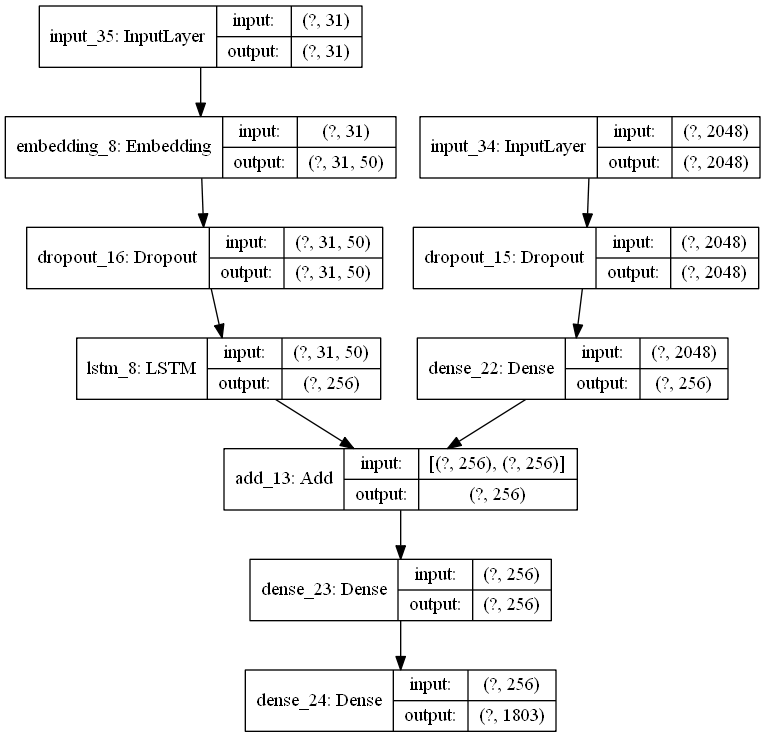

In [143]:
## Plotting the model architecture
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [144]:
## Model summary
final_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 31)           0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 31, 50)       90150       input_35[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 2048)         0           input_34[0][0]                   
____________________________________________________________________________________________

In [42]:
### Initializing weights of the embedding layer with embedding matrix & setting its trainability to false
final_model.layers[2].set_weights([embedding_matrix])
final_model.layers[2].trainable = False

In [43]:
## Compiling the model
final_model.compile(loss="categorical_crossentropy", optimizer="adam")

## Training the model

In [44]:
epochs = 20
batch_size = 6
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [87]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2030/2030 [==============================] - 1307s 644ms/step - loss: 4.0816
Epoch 1/1
2030/2030 [==============================] - 1148s 565ms/step - loss: 3.4101
Epoch 1/1
2030/2030 [==============================] - 1092s 538ms/step - loss: 3.1797
Epoch 1/1
2030/2030 [==============================] - 1080s 532ms/step - loss: 3.0386
Epoch 1/1
2030/2030 [==============================] - 1082s 533ms/step - loss: 2.9430
Epoch 1/1
2030/2030 [==============================] - 1100s 542ms/step - loss: 2.8697
Epoch 1/1
2030/2030 [==============================] - 1097s 540ms/step - loss: 2.8141
Epoch 1/1
2030/2030 [==============================] - 1093s 538ms/step - loss: 2.7686
Epoch 1/1
2030/2030 [==============================] - 16532s 8s/step - loss: 2.7290
Epoch 1/1
2030/2030 [==============================] - 1148s 566ms/step - loss: 2.6984
Epoch 1/1
2030/2030 [==============================] - 1153s 568ms/step - loss: 2.6727
Epoch 1/1
2030/2030 [========================

In [137]:
final_model.optimizer.learning_rate = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [323]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1015/1015 [==============================] - 535s 527ms/step - loss: 2.5260
Epoch 1/1
1015/1015 [==============================] - 564s 556ms/step - loss: 2.5222
Epoch 1/1
1015/1015 [==============================] - 561s 552ms/step - loss: 2.5162
Epoch 1/1
1015/1015 [==============================] - 640s 630ms/step - loss: 2.5113
Epoch 1/1
1015/1015 [==============================] - 626s 617ms/step - loss: 2.5097
Epoch 1/1
1015/1015 [==============================] - 606s 597ms/step - loss: 2.5018
Epoch 1/1
1015/1015 [==============================] - 631s 622ms/step - loss: 2.4983
Epoch 1/1
1015/1015 [==============================] - 607s 598ms/step - loss: 2.4991
Epoch 1/1
1015/1015 [==============================] - 608s 599ms/step - loss: 2.4912
Epoch 1/1
1015/1015 [==============================] - 606s 597ms/step - loss: 2.4906


In [365]:
for i in range(10, 20):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1015/1015 [==============================] - 556s 548ms/step - loss: 2.4870
Epoch 1/1
1015/1015 [==============================] - 597s 588ms/step - loss: 2.4821
Epoch 1/1
1015/1015 [==============================] - 619s 610ms/step - loss: 2.4767
Epoch 1/1
1015/1015 [==============================] - 625s 615ms/step - loss: 2.4787
Epoch 1/1
1015/1015 [==============================] - 623s 614ms/step - loss: 2.4735
Epoch 1/1
1015/1015 [==============================] - 625s 616ms/step - loss: 2.4695
Epoch 1/1
1015/1015 [==============================] - 629s 620ms/step - loss: 2.4687
Epoch 1/1
1015/1015 [==============================] - 626s 617ms/step - loss: 2.4656
Epoch 1/1
1015/1015 [==============================] - 627s 617ms/step - loss: 2.4660
Epoch 1/1
1015/1015 [==============================] - 622s 613ms/step - loss: 2.4602


In [432]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1015/1015 [==============================] - 523s 515ms/step - loss: 2.4556
Epoch 1/1
1015/1015 [==============================] - 560s 552ms/step - loss: 2.4535
Epoch 1/1
1015/1015 [==============================] - 569s 561ms/step - loss: 2.4484
Epoch 1/1
1015/1015 [==============================] - 573s 565ms/step - loss: 2.4484
Epoch 1/1
1015/1015 [==============================] - 553s 545ms/step - loss: 2.4450
Epoch 1/1
1015/1015 [==============================] - 559s 551ms/step - loss: 2.4444
Epoch 1/1
1015/1015 [==============================] - 552s 543ms/step - loss: 2.4400
Epoch 1/1
1015/1015 [==============================] - 567s 559ms/step - loss: 2.4408
Epoch 1/1
1015/1015 [==============================] - 575s 566ms/step - loss: 2.4393
Epoch 1/1
1015/1015 [==============================] - 564s 556ms/step - loss: 2.4346


In [46]:
## Loading the last saved model
final_model.load_weights('./model_weights/final_model_19.h5')

## Again training the model for overnight 😎

In [152]:
epochs = 20
batch_size = 6
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    final_model.save('./model_weights/final_model_' + str(i) + '.h5')

Epoch 1/1
2030/2030 [==============================] - 1157s 570ms/step - loss: 2.6609
Epoch 1/1
2030/2030 [==============================] - 1140s 562ms/step - loss: 2.6145
Epoch 1/1
2030/2030 [==============================] - 1307s 644ms/step - loss: 2.5966
Epoch 1/1
2030/2030 [==============================] - 1194s 588ms/step - loss: 2.5813
Epoch 1/1
2030/2030 [==============================] - 1177s 580ms/step - loss: 2.5668
Epoch 1/1
2030/2030 [==============================] - 1168s 576ms/step - loss: 2.5539
Epoch 1/1
2030/2030 [==============================] - 1170s 576ms/step - loss: 2.5428
Epoch 1/1
2030/2030 [==============================] - 1172s 577ms/step - loss: 2.5323
Epoch 1/1
2030/2030 [==============================] - 1171s 577ms/step - loss: 2.5234
Epoch 1/1
2030/2030 [==============================] - 1167s 575ms/step - loss: 2.5141
Epoch 1/1
2030/2030 [==============================] - 1172s 577ms/step - loss: 2.5071
Epoch 1/1
2030/2030 [======================

In [47]:
final_model.optimizer.learning_rate = 0.0001
epochs = 30
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    final_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    final_model.save('./model_weights/final_model_' + str(i) + '.h5')

Epoch 1/1
1015/1015 [==============================] - 569s 561ms/step - loss: 2.4552


AttributeError: 'float' object has no attribute 'numpy'

## `Loading the model`

In [46]:
final_model = load_model("./model_weights/final_model_19.h5")

In [47]:
final_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 31, 50)       90150       input_35[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 2048)         0           input_34[0][0]                   
____________________________________________________________________________________________

In [119]:
## Testing on test images
encoding_test

{'379006645_b9a2886b51': array([0.21914157, 0.5719447 , 0.        , ..., 0.6068711 , 0.03087302,
        0.36044884], dtype=float32),
 '380034515_4fbdfa6b26': array([0.29137012, 0.01306508, 0.6393796 , ..., 0.00232906, 0.08223425,
        0.14293307], dtype=float32),
 '380041023_0dfd712ef1': array([0.02699727, 0.09202066, 0.11031401, ..., 0.12098099, 0.19906935,
        0.15357533], dtype=float32),
 '380515798_c2abbf46b0': array([0.19967817, 0.04460802, 0.35637164, ..., 0.18070194, 0.71839666,
        0.29161525], dtype=float32),
 '380527679_574749123d': array([0.0434575 , 1.7292324 , 0.18306491, ..., 0.17492789, 1.6242176 ,
        1.7215117 ], dtype=float32),
 '380537190_11d6c0a412': array([0.08720243, 0.8569041 , 0.73614424, ..., 0.12408002, 2.4614062 ,
        1.0959768 ], dtype=float32),
 '380590140_25b9889772': array([0.37754437, 0.5835347 , 0.01128613, ..., 0.2976699 , 0.26250497,
        0.29707417], dtype=float32),
 '381052465_722e00807b': array([0.52440816, 0.35092583, 1.2005

In [48]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = final_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

z=-1
images = "data/Images/"

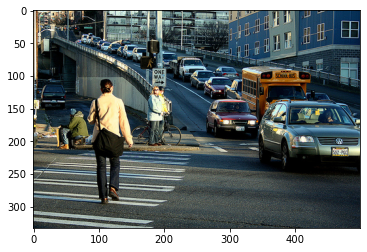

Greedy: group of people are sitting in front of large painted structure


In [72]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+".jpg")
plt.imshow(x)
plt.show()
print("Greedy:", greedySearch(image))

In [66]:
z=0

In [137]:
## z => 1,2, 4, 8, (13), 14, 17, 18, 19, 21, 10, 26, 30, 31, 34, 35, 40, 41,45, 51, 53, 54, 66, 69, 74, 75, 81, 82, 87, 88, 92, 93, 95, 99, 101, 102, 103, 110, 112, 115, 119, 125, 115, 116, 119, 120, 121, 123, 124, 125, 126, 128, 130, 131, 133, 135, 136, 141, 144, 150, 151, 154, 159, 160, 170, 173, 174, 176, 177, 178, 185, 201, 203, 212, 212, 214, 219, 221, 228, 230, 232, 247, 249, 257, 259, 263, 266, 270, 278, 284, 289, 290, 292, 319, 323, 328, 329, 338, 348, 366, 367, 370, 371, 376, 379, 386, 402, 407, 409, 411, 424, 427, 428, 452, 478

41

### Checking results one by one

In [8]:
from IPython.display import clear_output
import time

images_idx = [1,2, 4, 8, 13, 14, 17, 18, 19, 21, 10, 26, 30, 31, 34, 35, 41,45, 51, 53, 54, 69, 74, 75, 81, 82, 87, 88, 92, 93, 95, 99, 101, 102, 103, 110, 112, 115, 119, 125, 115, 116, 119, 120, 121, 123, 124, 125, 126, 128, 130, 131, 133, 135, 136, 141, 144, 150, 151, 154, 159, 160, 170, 173, 174, 176, 177, 178, 185, 201, 203, 212, 212, 214, 219, 221, 228, 230, 232, 247, 249, 257, 259, 263, 266, 270, 278, 284, 289, 290, 292, 319, 323, 328, 329, 338, 348, 366, 367, 370, 371, 376, 379, 386, 402, 407, 409, 411, 424, 427, 428, 452, 476, 478, 479, 481, 484, 487, 490, 492, 497, 498, 506, 508, 510, 513, 516, 521, 523, 524, 536, 524, 545, 549, 551, 554, 566, 595, 596, 597, 607, 621, 650, 657, 666, 669, 687, 694, 708]

for z in images_idx:
    pic = list(encoding_test.keys())[z]
    print(z)
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic+".jpg")
    plt.imshow(x)
    plt.show()
    print("Greedy:", greedySearch(image))
    clear_output(wait=True)
    input()

NameError: name 'encoding_test' is not defined

In [303]:
descriptions["263854883_0f320c1562"]

['the two small dogs run through the grass',
 'two fluffy white dogs running in green grass',
 'two small dogs run through the grass',
 'two small dogs that look almost identical are playing in the grass',
 'two yellow dogs run together in green grass']

## Testing on a random google image 🌟

In [456]:
image_name = "test_images/love_you_dp_wallpapers.jpg"

google_img = descriptencode_image(image_name)
test_image = google_img.reshape((1, 2048))
img = plt.imread(image_name)
plt.imshow(img)
plt.show()

print("Model Output: ", greedySearch(test_image))

AttributeError: 'numpy.ndarray' object has no attribute 'load_img'

## Trying the ideal model

In [37]:
## Library imports
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [117]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

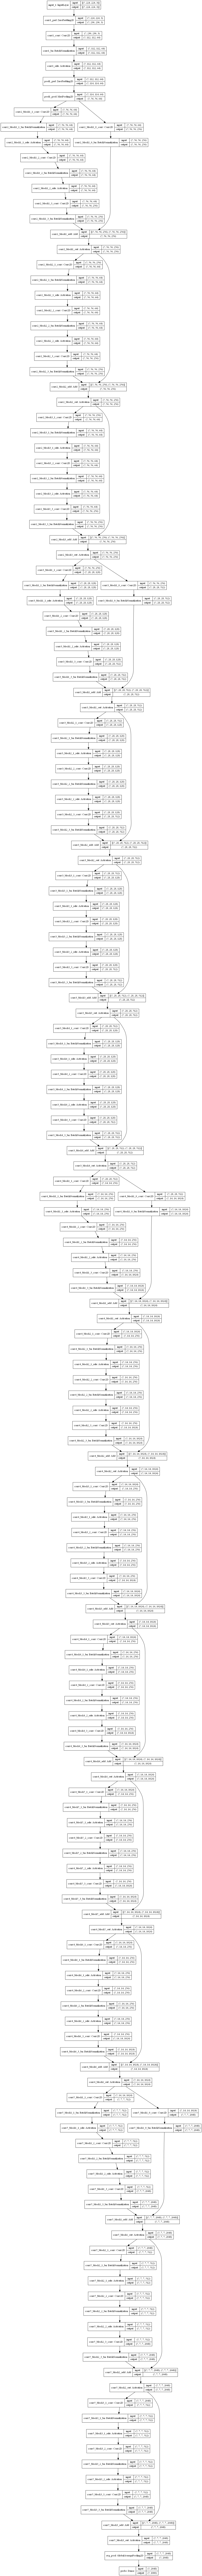

In [302]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__

C:\Users\YuvrajSK\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\YuvrajSK\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Num GPUs Available:  0


'2.1.0'

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [7]:
import numpy, pandas as pd
numpy.__version__, pd.__version__

('1.19.2', '1.1.5')

In [300]:
model.load_weights('./model_weights/model_9.h5')

OSError: Unable to open file (unable to open file: name = './model_weights/model_9.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)